In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Read datafiles
adnimerge = pd.read_csv("../Data/foi/ADNIMERGE.csv")
adnimerge = adnimerge[['RID','EXAMDATE','AGE','DX_bl','DX','Month_bl']]
adnimerge.head()

mem_ef = pd.read_csv("../Data/foi/UWNPSYCHSUM_10_27_17.csv")
bl = mem_ef[mem_ef.VISCODE =="bl"]
bl = bl[['RID','ADNI_MEM','ADNI_EF']]
bl.columns = ['RID','ADNI_MEM_bl','ADNI_EF_bl']
m = mem_ef[mem_ef.VISCODE != "bl"] 
m = m[['RID','EXAMDATE','ADNI_MEM','ADNI_EF']]



In [3]:
#Removing rows with NAs
mem = pd.merge(m,bl,on="RID")
mem = mem.dropna(axis=0, how='any')


In [4]:
#AdNImerge file - removing subjects that had the baseline diagnosis as AD
adnimerge.head()
adnimerge['EXAMDATE'] = pd.to_datetime(adnimerge['EXAMDATE'])
mem['EXAMDATE'] = pd.to_datetime(mem['EXAMDATE'])
x = pd.merge(mem,adnimerge,how='inner',on=['RID','EXAMDATE'])
x = x[x.DX_bl != "AD"]
x.head(10)

,RID,EXAMDATE,ADNI_MEM,ADNI_EF,ADNI_MEM_bl,ADNI_EF_bl,AGE,DX_bl,DX,Month_bl
0,2,2006-03-06,0.585,-0.197,0.503,-0.060,74.3,CN,CN,5.86885
1,2,2008-08-27,0.403,-0.008,0.503,-0.060,74.3,CN,CN,35.54100
2,2,2013-09-09,0.325,-0.726,0.503,-0.060,74.3,CN,CN,95.83610
3,2,2011-09-19,0.349,0.304,0.503,-0.060,74.3,CN,CN,72.19670
4,2,2010-09-22,0.352,-0.295,0.503,-0.060,74.3,CN,CN,60.32790
5,2,2015-09-22,0.384,-0.553,0.503,-0.060,74.3,CN,CN,120.19700
6,2,2012-09-26,0.425,-0.234,0.503,-0.060,74.3,CN,MCI,84.42620
10,4,2006-05-02,0.315,-0.688,0.116,-0.925,67.5,LMCI,MCI,5.73770
11,4,2007-05-14,0.548,-0.471,0.116,-0.925,67.5,LMCI,MCI,18.09840
12,4,2006-11-14,0.201,-0.743,0.116,-0.925,67.5,LMCI,MCI,12.16390


count    294.000000
mean      31.891713
std       26.857860
min        5.049180
25%       12.163900
50%       23.819700
75%       39.557400
max      119.869000
Name: Month_bl, dtype: float64

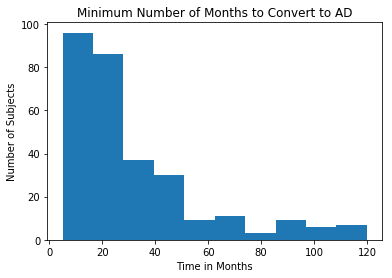

In [5]:
#Extracting subjects that converted to Dementia and checking the distribution of the minimum number of months for the
# change
x1 = x[x.DX_bl != x.DX]
x2 = x1[x1.DX == "Dementia"]
p = x2.groupby("RID")['Month_bl'].min()
plt.hist(p)
plt.xlabel('Time in Months')
plt.ylabel('Number of Subjects')
plt.title('Minimum Number of Months to Convert to AD')
p.describe()

In [6]:
#Using min and 75% cutoffs
ll = 5.04
ul = 39.55
q = pd.DataFrame({'RID':x2.RID.unique().tolist(), 'Month_bl':p.tolist()})
#Extracting the minimum Month_bl for subjects who convert to Dementia
z1 = pd.merge(x2,q,how='inner',on=['RID','Month_bl'])
z1 = z1[z1.Month_bl >ll]
z1 = z1[z1.Month_bl <ul]
t = p.tolist()
#Removing Dementia patients from the larger dataframe
x1 = x[~x.RID.isin(t)]
x1 = x1[x1.Month_bl >ll]
x1 = x1[x1.Month_bl <ul]
t1 = x1.RID.unique().tolist()
z2 = pd.DataFrame()
for i in t1:
    k = x1[x1.RID ==i]
    z2 = pd.concat([z2,k.sample(1)])


In [7]:
d = pd.concat([z1,z2])
d.describe()
ef_ch = []
mem_ch = []
#Deviation from baseline
d['EF_change'] = (d['ADNI_EF'] - d['ADNI_EF_bl'])/abs(d['ADNI_EF_bl'])
d['MEM_change'] = (d['ADNI_MEM'] - d['ADNI_MEM_bl'])/abs(d['ADNI_MEM_bl'])
d.head()


,RID,EXAMDATE,ADNI_MEM,ADNI_EF,ADNI_MEM_bl,ADNI_EF_bl,AGE,DX_bl,DX,Month_bl,EF_change,MEM_change
0,30,2006-04-13,-0.638,-0.378,-0.261,-0.394,80.0,LMCI,Dementia,5.73770,0.040609,-1.444444
1,41,2007-05-14,-1.575,0.732,-1.268,0.891,70.9,LMCI,Dementia,17.90160,-0.178451,-0.242114
2,42,2006-11-09,-0.030,0.103,-0.050,0.310,72.8,LMCI,Dementia,11.93440,-0.667742,0.400000
3,45,2007-03-07,-1.405,-0.735,-0.511,-0.211,85.9,LMCI,Dementia,13.77050,-2.483412,-1.749511
4,50,2006-06-07,-0.555,-2.384,-0.022,-1.709,77.6,LMCI,Dementia,6.13115,-0.394968,-24.227273


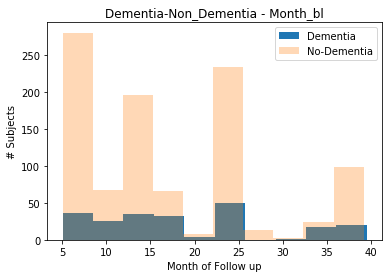

In [8]:
x = z1.Month_bl.tolist()
y = z2.Month_bl.tolist()
plt.hist(x,label="Dementia")
plt.title("Dementia-Non_Dementia - Month_bl")
plt.hist(y,alpha=0.3,label="No-Dementia")
plt.xlabel('Month of Follow up')
plt.ylabel('# Subjects')
plt.legend()


In [9]:

d['grp'] = np.where(d.DX == "Dementia", 'Dementia', 'No_Dementia')
d.head()
d.shape

(1210, 13)

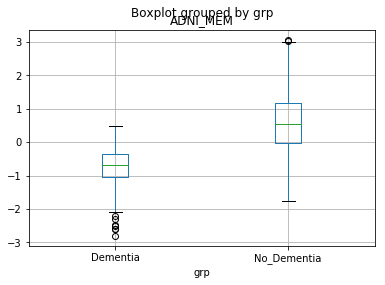

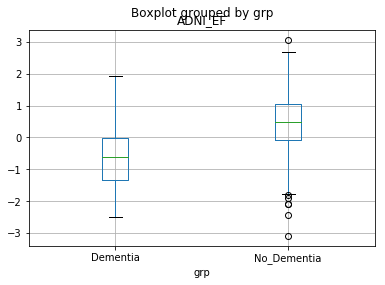

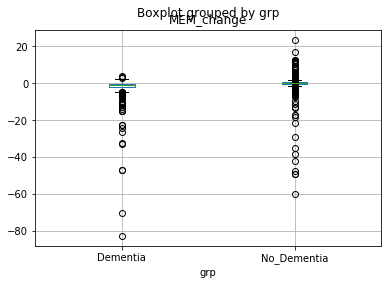

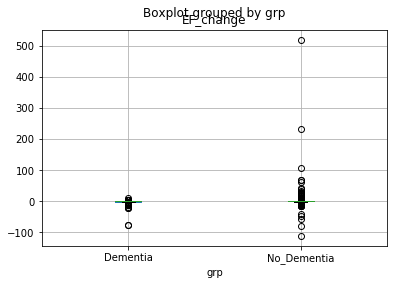

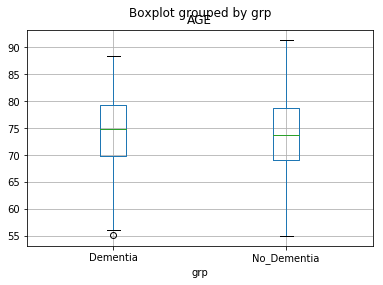

In [10]:
d.boxplot(column='ADNI_MEM', by='grp')
d.boxplot(column='ADNI_EF', by='grp')
d.boxplot(column='MEM_change', by='grp')
d.boxplot(column='EF_change', by='grp')
d.boxplot(column='AGE', by='grp')